In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("salary_data.csv")
df.head()

,age,city,education,salary
0,58,Yogyakarta,PhD,16377000
1,48,Surabaya,PhD,19344000
2,34,Surabaya,PhD,18322000
3,27,Jakarta,Highschool,5768000
4,40,Medan,PhD,16545000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        500 non-null    int64 
 1   city       500 non-null    object
 2   education  500 non-null    object
 3   salary     500 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 15.8+ KB


In [4]:
df.describe()

,age,salary
count,500.00000,5.000000e+02
mean,40.91800,1.160849e+07
std,11.89244,4.487952e+06
min,20.00000,3.000000e+06
25%,31.00000,8.083000e+06
50%,42.50000,1.134550e+07
75%,51.00000,1.468900e+07
max,60.00000,2.288200e+07


In [5]:
df.isnull().sum()

age          0
city         0
education    0
salary       0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
#Cek nama kolom pendidikan
urutan = df['education'].value_counts()
urutan

education
Master        133
Highschool    132
Bachelor      128
PhD           107
Name: count, dtype: int64

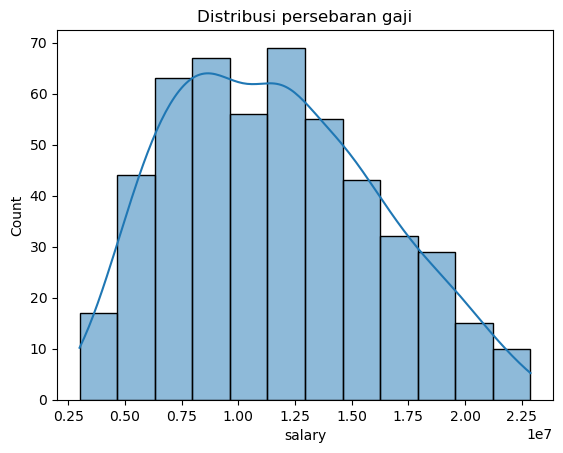

In [8]:
sns.histplot(df['salary'], kde=True)
plt.title("Distribusi persebaran gaji")
plt.show()

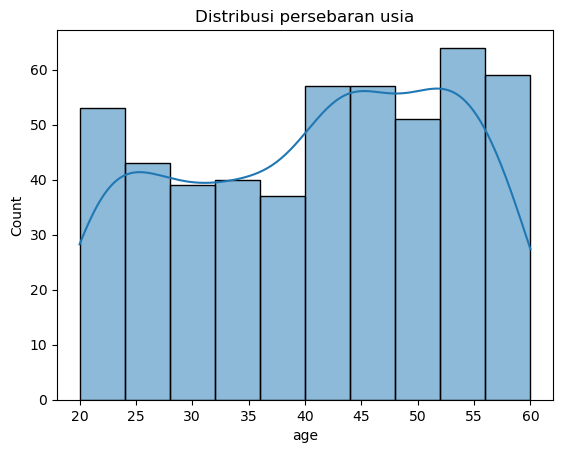

In [9]:
sns.histplot(df['age'], kde=True)
plt.title("Distribusi persebaran usia")
plt.show()

In [10]:
skew_umur = df['age'].skew()
skew_gaji = df['salary'].skew()

In [11]:
print("Kemiringan Grafik umur : ", skew_umur)
print("Kemiringan Grafik Gaji : ", skew_gaji)

Kemiringan Grafik umur :  -0.20204380367825966
Kemiringan Grafik Gaji :  0.33723551220580267


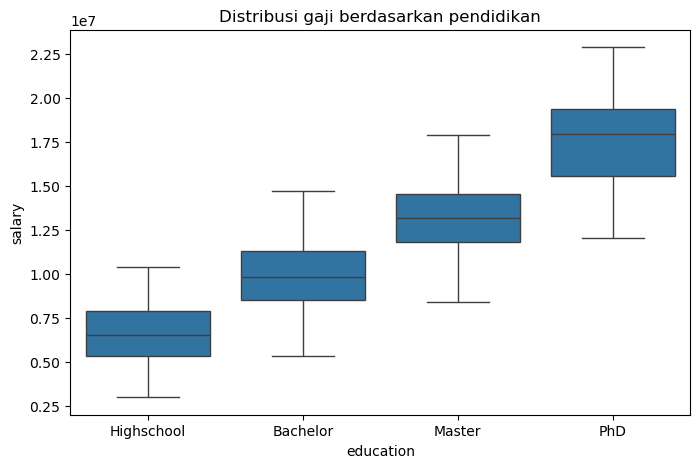

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(x='education', y='salary', data=df, order=['Highschool', 'Bachelor', 'Master', 'PhD'])
plt.title("Distribusi gaji berdasarkan pendidikan")
plt.show()

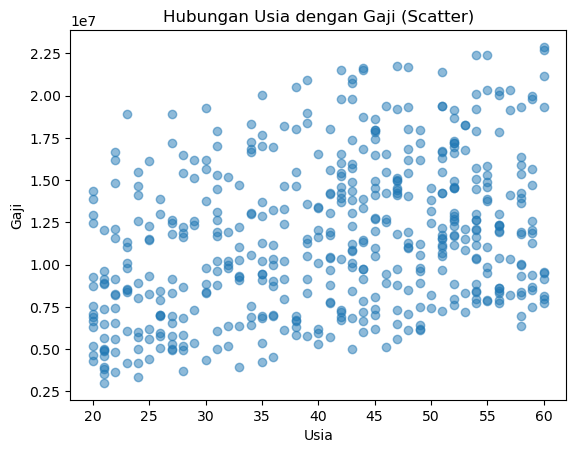

In [13]:
plt.scatter(df['age'], df['salary'], alpha=0.5)
plt.xlabel("Usia")
plt.ylabel("Gaji")
plt.title("Hubungan Usia dengan Gaji (Scatter)")
plt.show()

In [14]:
num_col = df.select_dtypes(include='int64')

In [15]:
num_col

,age,salary
0,58,16377000
1,48,19344000
2,34,18322000
3,27,5768000
4,40,16545000
...,...,...
495,49,9627000
496,36,9055000
497,39,18370000
498,44,9757000


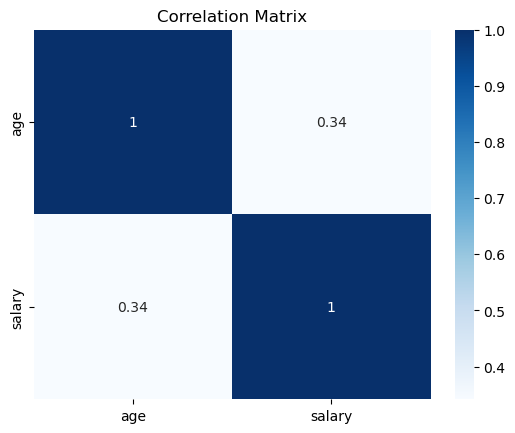

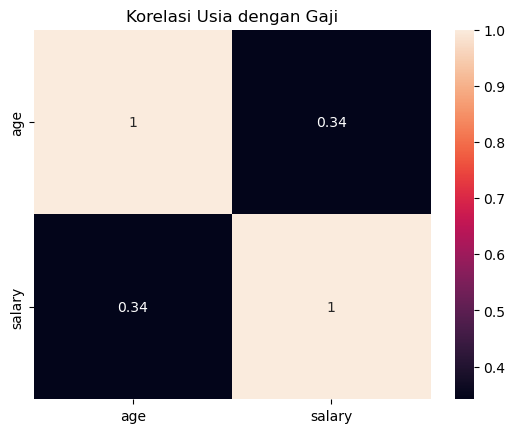

In [16]:
#Digunakan saat EDA
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Blues")
plt.title("Correlation Matrix")
plt.show()

#Digunakan saat Analisis lanjutan
num_corr = num_col.corr()
sns.heatmap(num_corr, annot=True)
plt.title("Korelasi Usia dengan Gaji")
plt.show()

In [17]:
df.nunique()

age           41
city           5
education      4
salary       487
dtype: int64

In [18]:
#Modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [19]:
#Pisahkan X dan y (target)
X = df[["age", "city", "education"]]
y = df["salary"]

In [20]:
#Split data 80% train dan 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
#Pisahkan data sesuai kategori
cat_nominal = ['city']
cat_ordinal = ['education']
num_ratio = ['age']
num_interval = [] #Dalam kasus ini, tidak ada

In [22]:
#Encode dan Scale seluruh kolom untuk memprediksi
preprocessor = ColumnTransformer(
    transformers=[
        ('city', OneHotEncoder(drop="first"), cat_nominal),
        ('education', OrdinalEncoder(categories=[["Highschool", "Bachelor", "Master", "PhD"]]), cat_ordinal),
        ('age', StandardScaler(), num_ratio)
    ]
)

In [23]:
#Buat dictionary jika ingin train lebih dari 1 model
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

In [24]:
param_grids = {
    "Linear Regression": {
        "model__fit_intercept": [True, False],
        "model__positive": [True, False]
    },
    "Random Forest": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [None, 5, 10],
        "model__min_samples_split": [2, 5]
    },
    "XGBoost": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.01, 0.1],
        "model__max_depth": [3, 5, 7]
    }
}

In [25]:
#Sedang dalam pemahaman
predictions = {}
res_param = []
results = []
trained_pipes = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=5,
        scoring="r2",
        n_jobs=-13
    )
    grid.fit(X_train, y_train)

    best_pipe = grid.best_estimator_ #best_estimator_ digunakan untuk memunculkan hasil refit model dari Cross-Validation
    y_pred = best_pipe.predict(X_test)

    predictions[name] = y_pred
    trained_pipes[name] = best_pipe
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Best CV R²": grid.best_score_,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "R²": round(r2, 3)
        #"Best Params": grid.best_params_
    })

    res_param.append({
        "Model": name,
        "Best Params": grid.best_params_
    })
    
results_df = pd.DataFrame(results)
res_param_df = pd.DataFrame(res_param)

In [26]:
#Memunculkan parameter terbaik

pd.set_option("display.max_colwidth", None)  # supaya tidak terpotong
# pd.set_option("display.max_columns", None)   # semua kolom terlihat
# pd.set_option("display.width", 1000)         # lebar tampilan console
print(res_param_df)

               Model  \
0  Linear Regression   
1      Random Forest   
2            XGBoost   

                                                                             Best Params  
0                               {'model__fit_intercept': True, 'model__positive': False}  
1  {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 100}  
2       {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}  


In [27]:
#Memunculkan metrik evaluasi
# pd.set_option("display.max_colwidth", None)  # supaya tidak terpotong
# pd.set_option("display.max_columns", None)   # semua kolom terlihat
# pd.set_option("display.width", 1000)         # lebar tampilan console
print(results_df)

               Model  Best CV R²        MAE       RMSE     R²
0  Linear Regression    0.969992  562774.41  727742.96  0.977
1      Random Forest    0.980690  445764.66  542522.80  0.987
2            XGBoost    0.983025  421865.44  512362.80  0.988


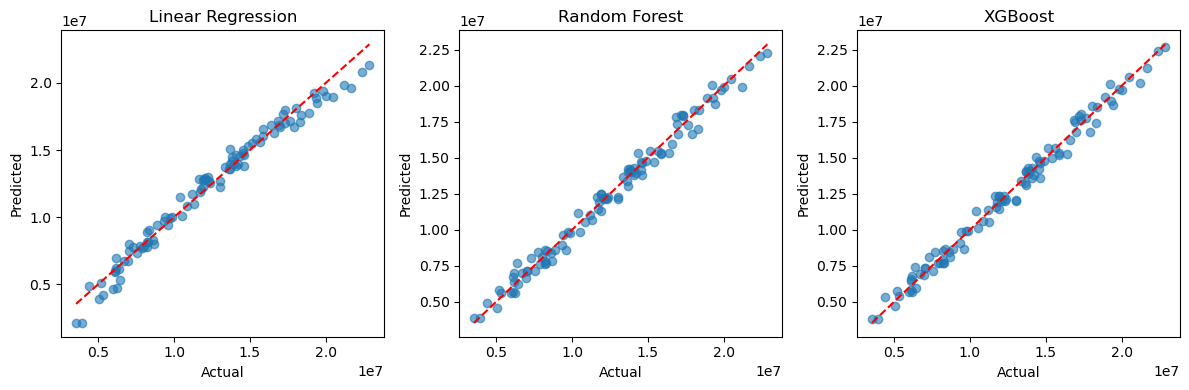

In [28]:
#Visualisasi hasil prediksi dengan scatter dengan data uji (test) garis linier
plt.figure(figsize=(12, 4))

for i, (name, y_pred) in enumerate(predictions.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--')  # garis ideal
    plt.title(name)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

plt.tight_layout()
plt.show()


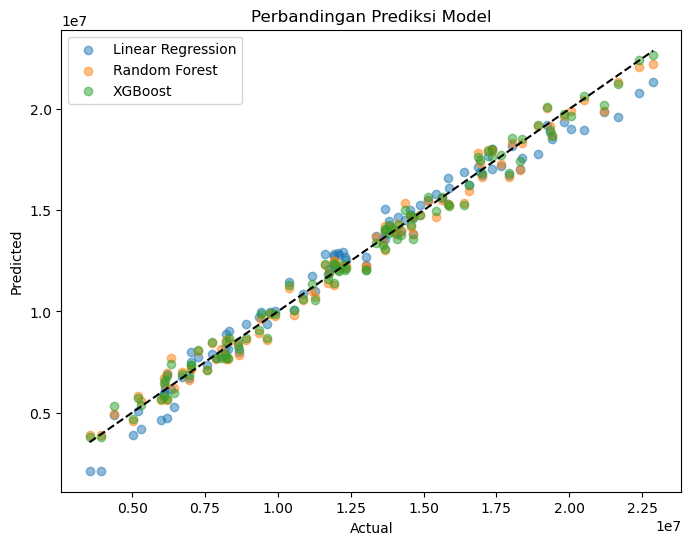

In [29]:
#Gabungan dari ketiga model dengan data uji (test) garis linier
plt.figure(figsize=(8,6))

for name, y_pred in predictions.items():
    plt.scatter(y_test, y_pred, alpha=0.5, label=name)

plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.title("Perbandingan Prediksi Model")
plt.show()


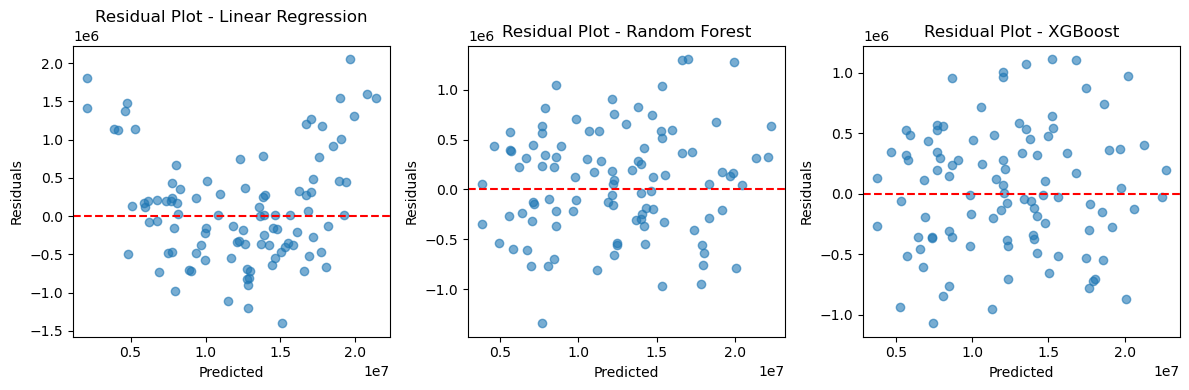

In [30]:
#Visualisasi hasil prediksi dengan residual plot (data uji - data prediksi)
plt.figure(figsize=(12, 4))

for i, (name, y_pred) in enumerate(predictions.items(), 1):
    residuals = y_test - y_pred
    
    plt.subplot(1, 3, i)
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')  # garis nol
    plt.title(f"Residual Plot - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")

plt.tight_layout()
plt.show()


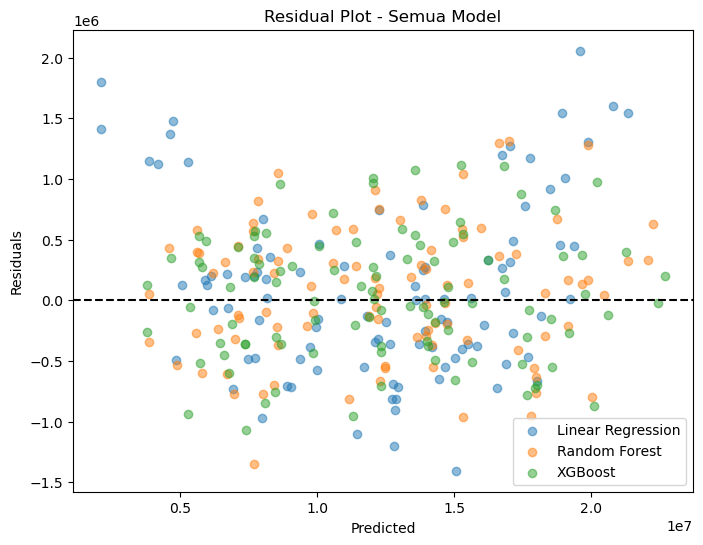

In [31]:
plt.figure(figsize=(8,6))

for name, y_pred in predictions.items():
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5, label=name)

plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot - Semua Model")
plt.legend()
plt.show()


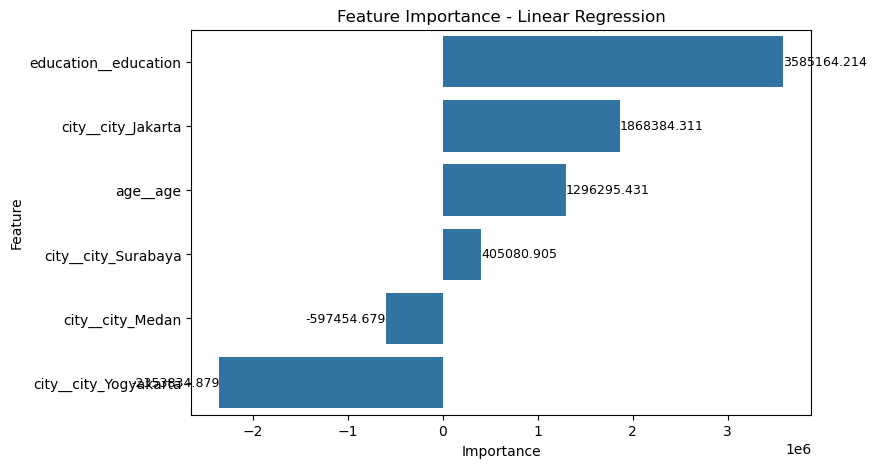

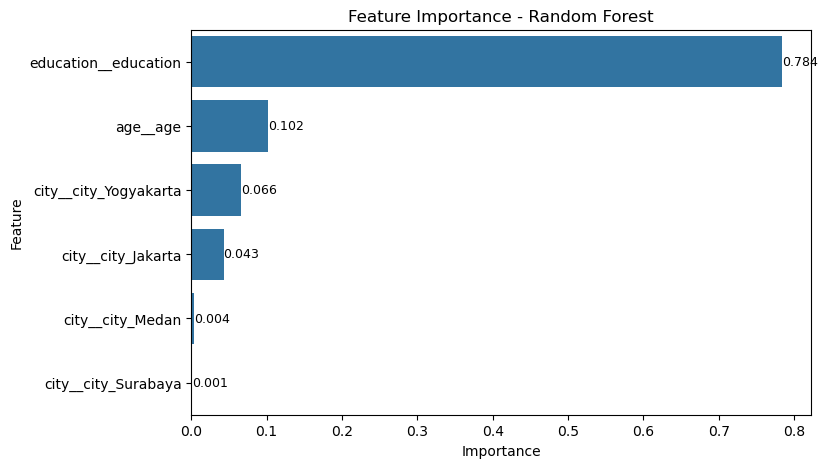

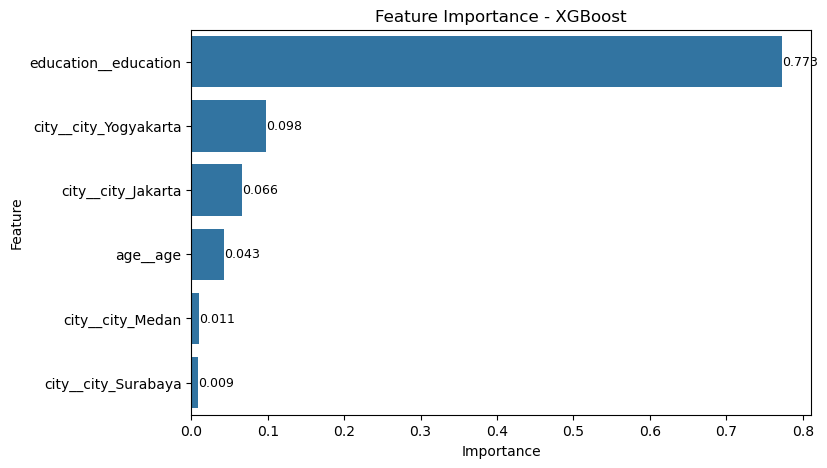

In [32]:
for name, pipe in trained_pipes.items():
    feature_names = pipe.named_steps["preprocessor"].get_feature_names_out()
    
    model = pipe.named_steps["model"]
    
    if hasattr(model, "coef_"):  # Linear Regression
        importances = model.coef_
    elif hasattr(model, "feature_importances_"):  # RF, XGB
        importances = model.feature_importances_
    else:
        continue
    
    df_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values("Importance", ascending=False)
    
    plt.figure(figsize=(8,5))
    ax = sns.barplot(data=df_importance, x="Importance", y="Feature")
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=9)
    plt.title(f"Feature Importance - {name}")
    plt.show()


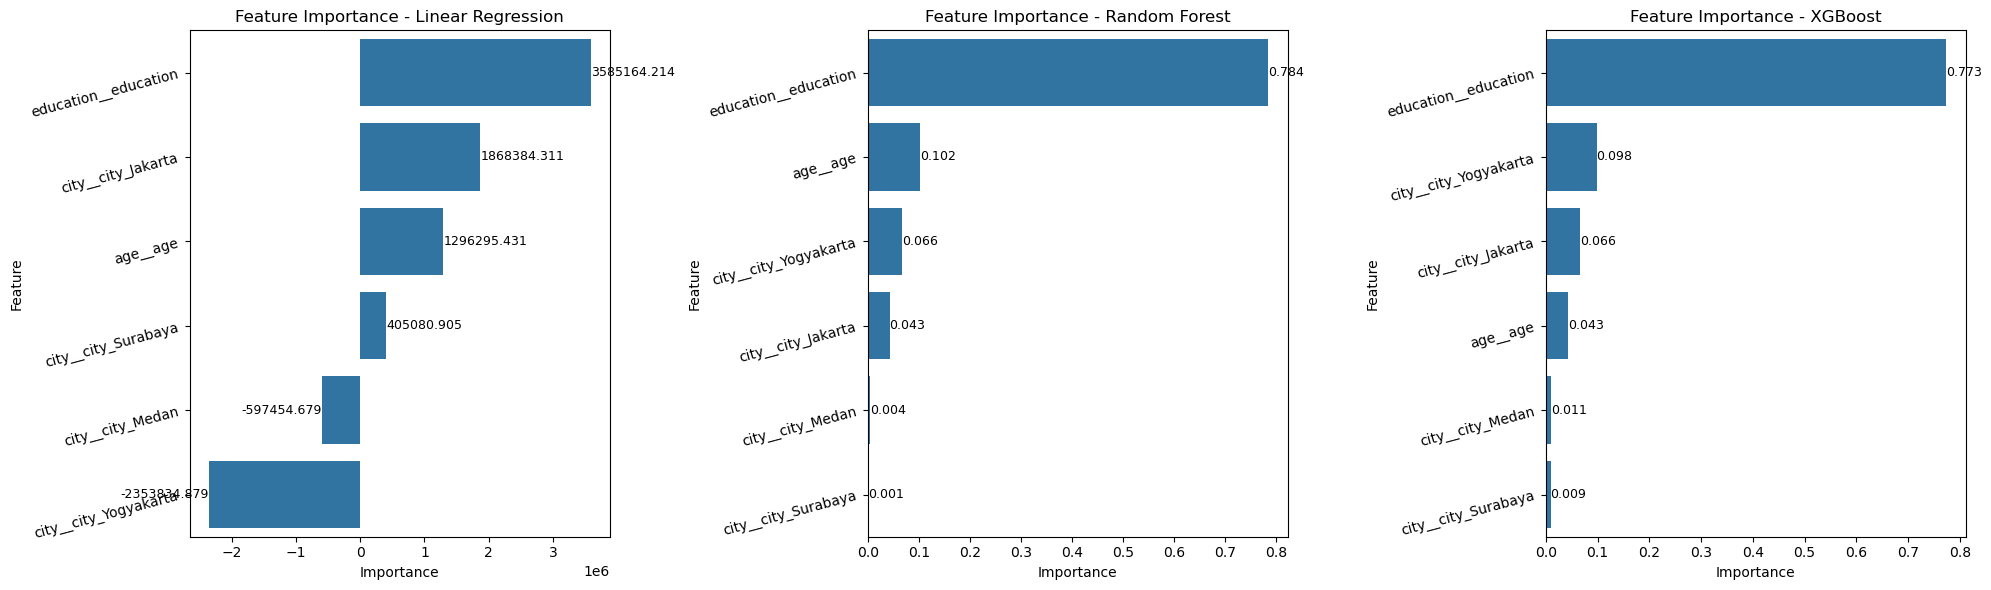

In [33]:
#Membuat feature importance (Advanced)

#buat subplots agar ketiga plot sejajar
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False) #jika sharey=True, maka sumbu x akan dibagi

for ax, (name, pipe) in zip(axes, trained_pipes.items()):
    feature_names = pipe.named_steps["preprocessor"].get_feature_names_out()
    model = pipe.named_steps["model"]
    
    if hasattr(model, "coef_"):  # Linear Regression
        importances = model.coef_
    elif hasattr(model, "feature_importances_"):  # RandomForest, XGB
        importances = model.feature_importances_
    else:
        continue
    
    df_importance = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values("Importance", ascending=False)
    
    sns.barplot(data=df_importance, x="Importance", y="Feature", ax=ax)
    ax.set_title(f"Feature Importance - {name}")
    ax.tick_params(axis='y', rotation=15) #Baseline memiringkan sumbu Y pada multimodel (Lebih dari 1 model)

    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=9) #Kode untuk memunculkn angka per bar

plt.tight_layout()
plt.show()


In [34]:
#Tentukan best model untuk presentasi ke stakeholder
final_result = pd.merge(results_df, res_param_df, on="Model")

#Normalisasi metrik evaluasi
# Normalisasi MAE
mae_scaler = MinMaxScaler()
final_result["MAE_norm"] = 1 - mae_scaler.fit_transform(final_result[["MAE"]])

# Normalisasi RMSE
rmse_scaler = MinMaxScaler()
final_result["RMSE_norm"] = 1 - rmse_scaler.fit_transform(final_result[["RMSE"]])

# Normalisasi R²
r2_scaler = MinMaxScaler()
final_result["R2_norm"] = r2_scaler.fit_transform(final_result[["R²"]])


#CRITICAL PROCESS
#Menentukan bobot per faktor (Sesuaikan dengan Kebutuhan bisnis/Domain problem)

'''Perlu pemahaman/pendekatan lebih lanjut untuk penentuan bobot'''

final_result["Final_Score"] = (
    0.4 * final_result["R2_norm"] +
    0.3 * final_result["MAE_norm"] +
    0.3 * final_result["RMSE_norm"]
)

#mengurutkan berdasarkan skor
final_result = final_result.sort_values(by="Final_Score", ascending=False) #ascending=False artinya mengurutkan dari nilai tertinggi ke rendah

#pilih model terbaik
best_model_name = final_result.iloc[0]["Model"]
best_params = final_result.iloc[0]["Best Params"]



In [35]:
final_result

,Model,Best CV R²,MAE,RMSE,R²,Best Params,MAE_norm,RMSE_norm,R2_norm,Final_Score
2,XGBoost,0.983025,421865.44,512362.80,0.988,"{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}",1.000000,1.000000,1.000000,1.000000
1,Random Forest,0.980690,445764.66,542522.80,0.987,"{'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 100}",0.830392,0.859969,0.909091,0.870745
0,Linear Regression,0.969992,562774.41,727742.96,0.977,"{'model__fit_intercept': True, 'model__positive': False}",0.000000,0.000000,0.000000,0.000000


In [36]:
#Versi simpel untuk menyimpan Best model (seluruh metrik evaluasi sudah ternormalisasi)
best_result_df = final_result.head(1)
best_result_df

,Model,Best CV R²,MAE,RMSE,R²,Best Params,MAE_norm,RMSE_norm,R2_norm,Final_Score
2,XGBoost,0.983025,421865.44,512362.8,0.988,"{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}",1.0,1.0,1.0,1.0


In [37]:
#Versi Advanced dan best practice untuk menyimpan Best Model
best_summary = pd.DataFrame([{
    "Best Model": best_model_name,
    "Best Params": best_params,
    "Final Score": final_result.iloc[0]["Final_Score"],
    "Test R²": final_result.iloc[0]["R²"],
    "Test MAE": final_result.iloc[0]["MAE"],
    "Test RMSE": final_result.iloc[0]["RMSE"]
}])

best_summary

,Best Model,Best Params,Final Score,Test R²,Test MAE,Test RMSE
0,XGBoost,"{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}",1.0,0.988,421865.44,512362.8


In [38]:
#Refit model terbaik dengan seluruh data train
best_model_names = best_summary.iloc[0]["Best Model"]
best_param = best_summary.iloc[0]["Best Params"]
#Ambil kelas model
best_model_class = models[best_model_names]

final_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_model_class.set_params(**best_param))
])

final_pipe.fit(X_train, y_train)

y_preds = final_pipe.predict(X_test)

C:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "model__learning_rate", "model__max_depth", "model__n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [39]:
# Ambil nama & params terbaik
best_model_name = best_summary.iloc[0]["Best Model"]
# Hapus prefix "model__" dari param
clean_params = {k.replace("model__", ""): v for k, v in best_params.items()}

# best_params = best_summary.iloc[0]["Best Params"]

# Ambil kelas model
best_model_class = models[best_model_name]

# Buat pipeline final
final_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_model_class.set_params(**clean_params))
])

# Latih ulang dengan data train
final_pipe.fit(X_train, y_train)

# Evaluasi ulang di test set
y_pred = final_pipe.predict(X_test)

print("Final Test R²:", r2_score(y_test, y_pred))
print("Final Test MAE:", mean_absolute_error(y_test, y_pred))
print("Final Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


Final Test R²: 0.9883938431739807
Final Test MAE: 421865.4375
Final Test RMSE: 512362.79946147534


C:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "model__learning_rate", "model__max_depth", "model__n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [40]:
best_pipe = trained_pipes[best_model_name]

# Fit ulang di full train set (opsional, kalau mau pastikan pakai semua data)
best_pipe.fit(X_train, y_train)

# Prediksi
y_pred = best_pipe.predict(X_test)

print("Final Test R²:", r2_score(y_test, y_pred))
print("Final Test MAE:", mean_absolute_error(y_test, y_pred))
print("Final Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Final Test R²: 0.9883938431739807
Final Test MAE: 421865.4375
Final Test RMSE: 512362.79946147534


In [41]:
# import shap

# # Ambil feature names dari preprocessor (sama untuk semua pipeline)
# feature_names = trained_pipes["Random Forest"].named_steps["preprocessor"].get_feature_names_out()
# X_test_transformed = trained_pipes["Random Forest"].named_steps["preprocessor"].transform(X_test)

# # Loop hanya untuk tree-based models
# for name in ["Random Forest", "XGBoost"]:
#     print(f"=== SHAP Summary untuk {name} ===")

#     # Ambil pipeline terbaik dari hasil GridSearchCV
#     best_pipe = trained_pipes[name]
#     model = best_pipe.named_steps["model"]

#     # Pastikan data test sudah ditransformasi
#     X_test_transformed = best_pipe.named_steps["preprocessor"].transform(X_test)

#     # Gunakan TreeExplainer (khusus RandomForest & XGBoost)
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X_test_transformed)

#     # Plot summary
#     shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)


=== SHAP Summary untuk Random Forest ===


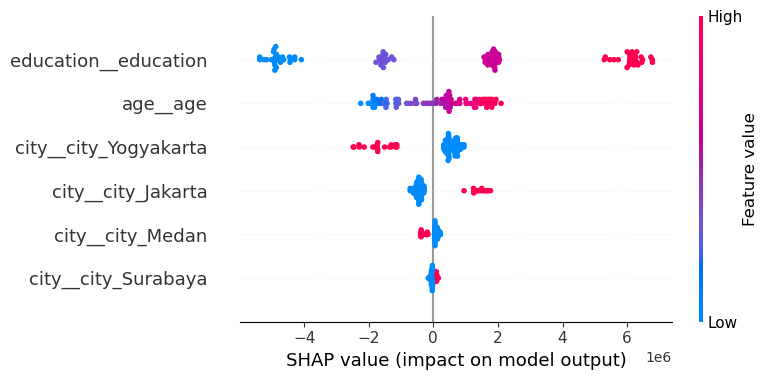

=== SHAP Summary untuk XGBoost ===


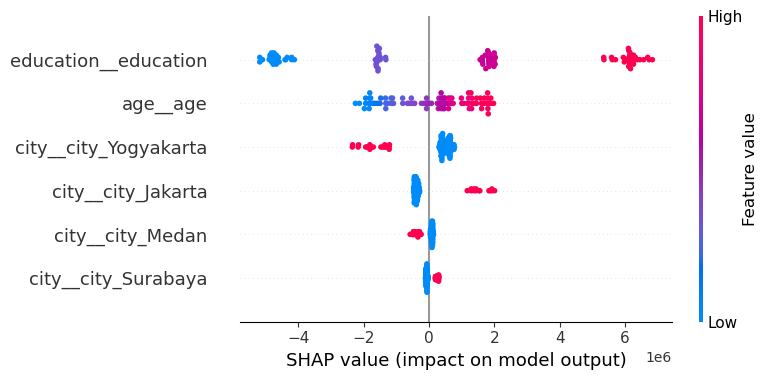

In [42]:
#Visualisasi SHAP

import shap
# Loop hanya untuk tree-based models
for name in ["Random Forest", "XGBoost"]:
    print(f"=== SHAP Summary untuk {name} ===")

    # Ambil pipeline terbaik dari hasil GridSearchCV
    best_pipe = trained_pipes[name]
    model = best_pipe.named_steps["model"]

    # Pastikan data test sudah ditransformasi
    X_test_transformed = best_pipe.named_steps["preprocessor"].transform(X_test)

    # Gunakan TreeExplainer (khusus RandomForest & XGBoost)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_transformed)

    # Plot summary
    shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

In [43]:
trained_pipes[best_model_name]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('city',
                                                  OneHotEncoder(drop='first'),
                                                  ['city']),
                                                 ('education',
                                                  OrdinalEncoder(categories=[['Highschool',
                                                                              'Bachelor',
                                                                              'Master',
                                                                              'PhD']]),
                                                  ['education']),
                                                 ('age', StandardScaler(),
                                                  ['age'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [44]:
import joblib

joblib.dump(trained_pipes[best_model_name], "salary_predictor.pkl")

['salary_predictor.pkl']

In [46]:
!python --version

Python 3.13.5
